In [19]:
# Only using an 830-subject subset of the PNC dataset

import pickle
import numpy as np

dr = '/home/anton/Documents/Tulane/Research/ImageNomer/data/test/'
demo = pickle.load(open(f'{dr}/demographics.pkl', 'rb'))

snps = []
rest = []
nback = []
emoid = []
wrat = []
race = []

for sub,val in demo['wrat'].items():
    r = np.load(f'{dr}/conn/{sub}_task-rest_fc.npy')
    n = np.load(f'{dr}/conn/{sub}_task-nback_fc.npy')
    e = np.load(f'{dr}/conn/{sub}_task-emoid_fc.npy')
    s = np.load(f'{dr}/snps/{sub}_set-big_snps.npy')
    rac = demo['race'][sub]
    race.append(rac == 'EA')
    s[np.isnan(s)] = 0
    wrat.append(val)
    snps.append(s - 1)
    # snps1.append(2*(s == 0)+(s==1))
    # snps2.append(2*(s == 2)+(s==1))
    rest.append(r)
    nback.append(n)
    emoid.append(e)

# snps1 = np.stack(snps1)
# snps2 = np.stack(snps2)
# snps = np.concatenate([snps1, snps2], axis=1)
snps = np.stack(snps)
rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
wrat = np.array(wrat)

print([x.shape for x in [snps, rest, nback, emoid, wrat]])

[(830, 35621), (830, 34716), (830, 34716), (830, 34716), (830,)]


In [95]:
# LatSim Model

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

def to_cuda(x):
    try:
        return x.float().cuda()
    except:
        return x.float()

class LatSim(nn.Module):
    def __init__(self, d1, d2, ld=2):
        super(LatSim, self).__init__()
        self.A1 = nn.Linear(d1, 1).float().cuda()
        self.A2 = nn.Linear(d2, 1).float().cuda()

    def E(self, xtr, xt):
        # Similarity matrix
        AT = self.A1(xtr).T
        A = self.A2(xt)
        E = A@AT
        return F.softmax(E,dim=1)

    def get_w_inp_mag(self, xtr):
        with torch.no_grad():
            A = self.A1.weight.data[0]
            return A, torch.argsort(A)
        
    def forward(self, xtr, ytr, xt=None):
        if xt is None:
            xt = xtr
        E = self.E(xtr, xt)
        return E@ytr

tot = 0
totNull = 0
avg = []

for i in range(10):
    x1tr, x1t, x2tr, x2t, x3tr, x3t, x4tr, x4t, ytr, yt = train_test_split(
        snps, rest, nback, emoid, wrat, train_size=0.99)
    
    xtr1 = to_cuda(torch.from_numpy(x1tr))/10
    xtr2 = to_cuda(torch.from_numpy(x1tr))/10
    ytr1 = to_cuda(torch.from_numpy(ytr))
    xt = to_cuda(torch.from_numpy(x1t))/10
    
    latsim = LatSim(xtr1.shape[1], xtr2.shape[1], ld=2)
    optim = torch.optim.Adam(latsim.parameters(), lr=1e-4, weight_decay=1e-4)
    nepochs = 100
    pperiod = 100
    
    def rmse(a, b, mean=torch.mean):
        return mean((a-b)**2)**0.5
    
    for e in range(nepochs):
        optim.zero_grad()
        yhat = latsim(xtr1, ytr1, xtr2)
        loss = rmse(yhat, ytr1)
        loss.backward()
        optim.step()
        if e%pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)}')
    
    with torch.no_grad():
        yhat = latsim(xtr1, ytr1, xt)
        yhat = yhat.detach().cpu().numpy()
        loss = rmse(yhat, yt, np.mean)
        print(loss)
        print(np.std(yt))
        tot += loss
        totNull += np.std(yt)
        avg.append(loss)

print(np.std(avg))

0 15.906216621398926
99 5.88309907913208
9.839715168402481
9.66091783079296
0 15.916999816894531
99 6.116838455200195
7.567669602537463
8.406346808612328
0 15.896937370300293
99 5.443325996398926
13.337300545465547
9.786612170602131
0 15.815990447998047
99 5.461248874664307
15.504538100978113
19.470775822013643
0 15.886124610900879
99 5.509968280792236
14.741456088405975
13.389695688001424
0 15.878619194030762
99 6.518762111663818
10.312044550188311
14.102797200870786
0 15.874225616455078
99 5.479102611541748
11.377254799884815
14.590712418826193
0 15.77510929107666
99 6.034982681274414
18.39086642079808
22.005610956759345
0 15.880758285522461
99 5.517732620239258
11.568174958797503
13.934591472525229
0 15.802367210388184
99 5.89864444732666
20.316127357682586
20.256381405727947
3.775435945865967


In [96]:
print(tot/10)
print(totNull/10)

13.295514759314084
14.560444177473197


In [97]:
w_inp, rank = latsim.get_w_inp_mag(xtr1)
rank = torch.flip(rank, dims=[0])
print(w_inp[rank])
for i in range(20):
    print(int(rank[i]))
for i in range(20):
    print(float(w_inp[rank[i]]))

tensor([ 0.0194,  0.0191,  0.0190,  ..., -0.0193, -0.0193, -0.0194],
       device='cuda:0')
8307
682
22776
33799
9406
15027
14788
5492
32818
10171
11717
17519
32381
26137
9773
21069
17924
3831
16998
19670
0.019388921558856964
0.019095174968242645
0.018974632024765015
0.018886711448431015
0.018857013434171677
0.018797168508172035
0.01873188465833664
0.018730156123638153
0.018714092671871185
0.018703756853938103
0.018670059740543365
0.018653808161616325
0.018644699826836586
0.018590424209833145
0.01858809031546116
0.018575171008706093
0.018561404198408127
0.018554551526904106
0.018544528633356094
0.018532680347561836


In [107]:
for j in range(20):
    aa = [0,0,0]
    ea = [0,0,0]
    for i in range(830):
        s = int(snps[i,rank[j]])
        if race[i] == 'AA':
            aa[s+1] += 1
        elif race[i] == 'EA':
            ea[s+1] += 1
    print(rank[j])
    # print(aa)
    # print(ea)
    print((2*aa[2]+aa[1])/((aa[0]+aa[1]+aa[2])*2))
    print((2*ea[2]+ea[1])/((ea[0]+ea[1]+ea[2])*2))

3700
0.696319018404908
0.5651105651105651
19994
0.32515337423312884
0.7628992628992629
3796
0.6349693251533742
0.8771498771498771
26839
0.5076687116564417
0.7162162162162162
17085
0.8911042944785276
0.5417690417690417
16970
0.5230061349693251
0.6093366093366094
27670
0.5705521472392638
0.5098280098280098
32231
0.74079754601227
0.5540540540540541
8272
0.5138036809815951
0.8353808353808354
4758
0.3282208588957055
0.7334152334152334
9026
0.38496932515337423
0.6425061425061425
4781
0.3236196319018405
0.8759213759213759
7715
0.5904907975460123
0.8894348894348895
24010
0.48466257668711654
0.8771498771498771
33828
0.24233128834355827
0.7776412776412777
8941
0.8098159509202454
0.4975429975429975
13961
0.40644171779141103
0.9557739557739557
26722
0.7147239263803681
0.36732186732186733
1442
0.3389570552147239
0.7113022113022113
18297
0.4570552147239264
0.7211302211302212


In [104]:
from sklearn.linear_model import Ridge, Lasso

x1tr, x1t, x2tr, x2t, x3tr, x3t, x4tr, x4t, ytr, yt = train_test_split(
        snps, rest, nback, emoid, wrat, train_size=0.99)

reg = Lasso(alpha=1).fit(x1tr, ytr)
yhat = reg.predict(x1t)
loss = rmse(yhat, yt, mean=np.mean)
null = np.std(yt)
print(loss, null)

w = np.abs(reg.coef_)
rank = np.argsort(w)[::-1]
for i in range(20):
    print(int(rank[i]))
for i in range(20):
    print(float(w[rank[i]]))

11.366475330402743 10.718623460542352
3700
19994
3796
26839
17085
16970
27670
32231
8272
4758
9026
4781
7715
24010
33828
8941
13961
26722
1442
18297
1.5137300934826257
1.0538145532246388
1.0153484423618329
0.8993046698792628
0.8663701461513902
0.725293258831969
0.705664976123019
0.7035693298162788
0.6368422705608945
0.6306794859434997
0.5316292760142316
0.5299409920328537
0.5013173435554522
0.4909784450175028
0.45500889364591646
0.44839658168401414
0.41962325953668567
0.415109347801941
0.35542558644392036
0.345462020776891


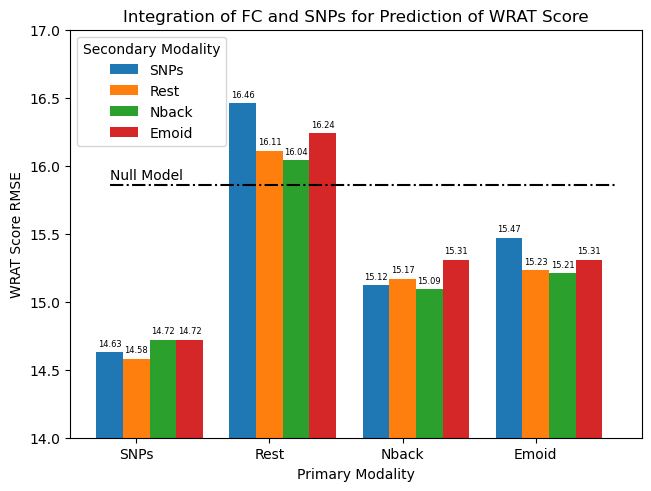

In [28]:
import matplotlib.pyplot as plt

primary_modality = ['SNPs', 'Rest', 'Nback', 'Emoid']
data = {
    'SNPs': (14.63, 16.46, 15.12, 15.47),
    'Rest': (14.58, 16.11,  15.17, 15.23),
    'Nback': (14.72, 16.04, 15.09, 15.21),
    'Emoid': (14.72, 16.24, 15.31, 15.31)
}
x = np.arange(len(primary_modality))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for secondary_modality, val in data.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, val, width, label=secondary_modality)
    ax.bar_label(rects, padding=3, size=6)
    multiplier += 1

ax.plot([0, 3.8], [15.86, 15.86], linestyle='-.', color='black')
ax.annotate('Null Model', [0, 15.9])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('WRAT Score RMSE')
ax.set_title('Integration of FC and SNPs for Prediction of WRAT Score')
ax.set_xticks(x + width, primary_modality)
ax.legend(loc='upper left', title='Secondary Modality')
ax.set_ylim(14, 17)
ax.set_xlabel('Primary Modality')

fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Dissertation/FigureIntegrationSNPs.pdf')

In [3]:
aadist = []
eadist = []
for j in range(snps.shape[1]):
    aa = [0,0,0]
    ea = [0,0,0]
    for i in range(830):
        s = int(snps[i,j])
        if race[i] == 'AA':
            aa[s+1] += 1
        elif race[i] == 'EA':
            ea[s+1] += 1
    aadist.append((2*aa[2]+aa[1])/((aa[0]+aa[1]+aa[2])*2))
    eadist.append((2*ea[2]+ea[1])/((ea[0]+ea[1]+ea[2])*2))
print(np.mean(aadist))
print(np.mean(eadist))

0.7311283083684523
0.7405914518993881


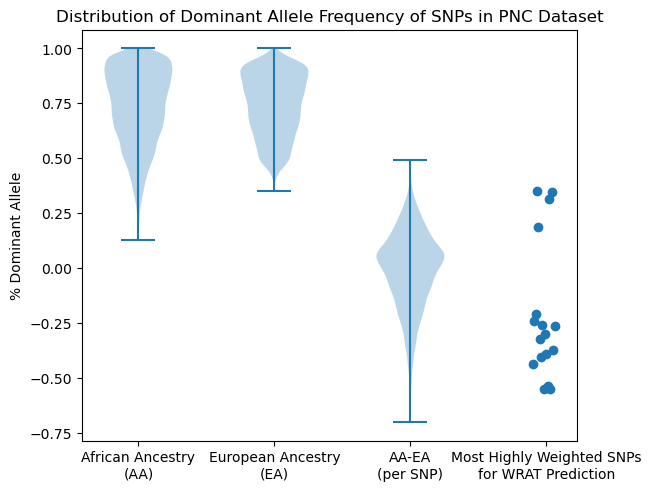

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(layout='constrained')

aa = [#0.6963190184,
      0.3251533742,
      0.6349693252,
      0.5076687117,
      0.8911042945,
      #0.523006135,
      #0.5705521472,
      0.740797546,
      0.513803681,
      0.3282208589,
      0.3849693252,
      0.3236196319,
      0.5904907975,
      0.4846625767,
      0.2423312883,
      0.8098159509,
      0.4064417178,
      0.7147239264,
      0.3389570552,
      0.4570552147]

ea = [#0.5651105651,
      0.7628992629,
      0.8771498771,
      0.7162162162,
      0.5417690418,
      #0.6093366093,
      #0.5098280098,
      0.5540540541,
      0.8353808354,
      0.7334152334,
      0.6425061425,
      0.8759213759,
      0.8894348894,
      0.8771498771,
      0.7776412776,
      0.4975429975,
      0.9557739558,
      0.3673218673,
      0.7113022113,
      0.7211302211]

ax.violinplot([aadist, eadist, np.array(aadist)-np.array(eadist)])
ax.scatter(3.9+np.arange(17)*0.01, np.array(aa)-np.array(ea))

ax.set_title("Distribution of Dominant Allele Frequency of SNPs in PNC Dataset")
ax.set_ylabel("% Dominant Allele")
ax.set_xticks([1,2,3,4],["African Ancestry\n(AA)", "European Ancestry\n(EA)", "AA-EA\n(per SNP)", "Most Highly Weighted SNPs\nfor WRAT Prediction"])

fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Dissertation/FigureDominantAllele.pdf')

In [7]:
for i in range(20):
    print(i, aa[i]-ea[i])

0 0.13120845329999997
1 -0.4377458887
2 -0.24218055189999999
3 -0.20854750449999993
4 0.3493352527
5 -0.08633047429999996
6 0.060724137400000044
7 0.18674349190000006
8 -0.3215771544
9 -0.4051943745
10 -0.25753681730000005
11 -0.552301744
12 -0.29894409190000004
13 -0.3924873004
14 -0.7134426675000001
15 0.34740205910000005
16 -0.3723451561
17 -0.26407500640000003


IndexError: list index out of range

In [24]:
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

def rmse(a, b, mean=np.mean):
    return mean((a-b)**2)**0.5

x1tr, x1t, x2tr, x2t, x3tr, x3t, x4tr, x4t, ytr, yt, y2tr, y2t = train_test_split(
        snps, rest, nback, emoid, wrat, race, train_size=0.8)

reg = Ridge(alpha=100).fit(x3tr, ytr)
yhat = reg.predict(x3t)
loss = rmse(yhat, yt, mean=np.mean)
null = np.std(yt)
print(loss, null)

w = reg.coef_
print(w.shape)

reg = LogisticRegression(C=10).fit(x3tr, y2tr)
yhat = reg.predict(x3t)
loss = np.mean(np.abs(yhat == y2t))
print(loss)

w2 = reg.coef_[0]
print(w2.shape)

15.07075816325073 15.845229860551735
(34716,)
0.7289156626506024
(34716,)


In [22]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


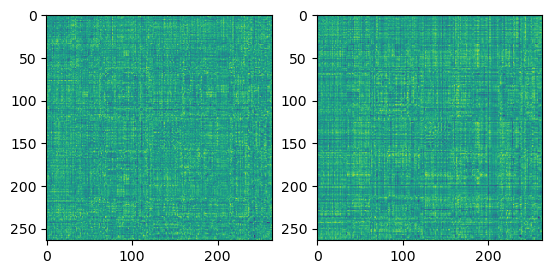

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].imshow(remap(vec2mat(-w)))
ax[1].imshow(remap(vec2mat(w2)))

fig.show()